<a href="https://colab.research.google.com/github/yurigalindo/modelagem_computacional/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg




--2019-11-19 21:52:15--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.04s   

2019-11-19 21:52:15 (2.99 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2019-11-19 21:52:17--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.01s   

2019-11-19 21:52:17 (3.18 MB/s) - ‘dancing.jpg’ saved [40484/40484]



In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

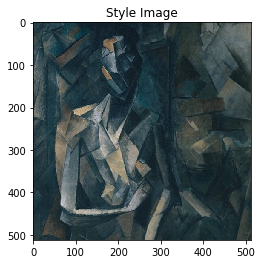

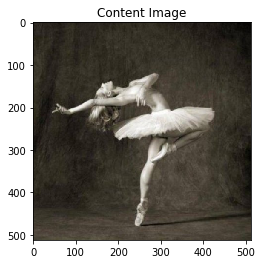

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [6]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 161MB/s]


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv4_2']
style_layers_default = [
                        'conv1_1', 'conv2_1',
                        'conv3_1', 
                        'conv4_1', 'conv5_1'
                       ]

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 1  # increment every time we see a conv
    j= 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            j += 1
            name = 'conv{}_{}'.format(i,j)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(i,j)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            i+=1
            j=0
            name = 'pool_{}'.format(i)
            layer=nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride or layer.kernel_size, padding=layer.padding, 
                               ceil_mode=layer.ceil_mode)
            #Replace by avg pool to make end image smoother

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(i,j)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [0]:
#input_img = content_img.clone()
#input_img=style_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)
input_img = torch.ones(content_img.data.size(), device=device)


In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 0.645467 Content Loss: 0.902415

run [100]:
Style Loss : 0.359969 Content Loss: 0.570361

run [150]:
Style Loss : 0.279716 Content Loss: 0.463613

run [200]:
Style Loss : 0.220858 Content Loss: 0.408851

run [250]:
Style Loss : 0.181497 Content Loss: 0.378052

run [300]:
Style Loss : 0.160145 Content Loss: 0.356166



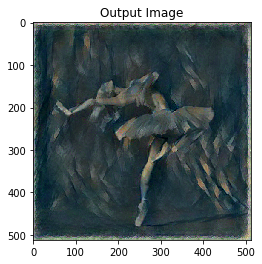

In [23]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=300,style_weight=1000000)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

--2019-06-19 22:08:36--  https://cdn.britannica.com/s:500x350/78/43678-004-8F18BDDF.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 13.249.87.109, 13.249.87.69, 13.249.87.104, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|13.249.87.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45352 (44K) [image/jpeg]
Saving to: ‘43678-004-8F18BDDF.jpg’

43678-004-8F18BDDF. 100%[===================>]  44.29K  --.-KB/s    in 0.01s   

2019-06-19 22:08:36 (3.42 MB/s) - ‘43678-004-8F18BDDF.jpg’ saved [45352/45352]

--2019-06-19 22:08:38--  http://blog.artweekenders.com/wp-content/uploads/2014/01/Scream3.jpg
Resolving blog.artweekenders.com (blog.artweekenders.com)... 173.205.127.244
Connecting to blog.artweekenders.com (blog.artweekenders.com)|173.205.127.244|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93714 (92K) [image/jpeg]
Saving to: ‘Scream3.jpg’

Scream3.jpg         100%[===================>]  91.52K  --.-KB/s    in 0.

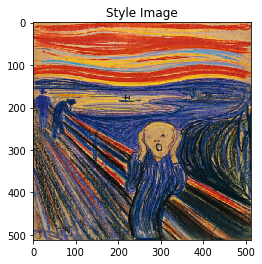

Building the style transfer model..


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 8.730374 Content Loss: 8.772409

run [100]:
Style Loss : 5.490579 Content Loss: 5.629274

run [150]:
Style Loss : 4.460582 Content Loss: 4.553357

run [200]:
Style Loss : 3.914157 Content Loss: 3.990704

run [250]:
Style Loss : 3.558755 Content Loss: 3.640893

run [300]:
Style Loss : 3.300672 Content Loss: 3.395291

run [350]:
Style Loss : 3.101607 Content Loss: 3.197346

run [400]:
Style Loss : 2.942338 Content Loss: 3.033047

run [450]:
Style Loss : 2.814855 Content Loss: 2.894354

run [500]:
Style Loss : 2.713930 Content Loss: 2.782677

run [550]:
Style Loss : 2.622110 Content Loss: 2.680818

run [600]:
Style Loss : 2.549474 Content Loss: 2.595381

run [650]:
Style Loss : 2.491497 Content Loss: 2.514512

run [700]:
Style Loss : 2.437288 Content Loss: 2.446395

run [750]:
Style Loss : 2.392984 Content Loss: 2.380678

run [800]:
Style Loss : 2.369082 Content Loss: 2.349130

run [850]:
Style Loss : 2.316646 Content Loss: 2.264422

run [900]:
Style Lo

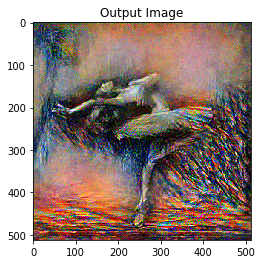

In [0]:
!wget https://cdn.britannica.com/s:500x350/78/43678-004-8F18BDDF.jpg
!wget http://blog.artweekenders.com/wp-content/uploads/2014/01/Scream3.jpg
!wget https://afremov.com/images/product/image_860.jpeg
style_img = image_loader("Scream3.jpg")
plt.figure()
imshow(style_img, title='Style Image')
input_img = torch.ones(content_img.data.size(), device=device)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,style_weight=2000)


plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


In [0]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

NameError: ignored